In [34]:
# Install required library: pip install noise
import numpy as np
from scipy.spatial.transform import Rotation as R
import noise

# Set parameters
T = 20.0  # Total simulation time (seconds)
dt = 0.01  # Time step (seconds, 100 Hz)
g = 9.81  # Gravity constant (m/s^2)
np.random.seed(2)  # For reproducibility


# Create time array
t = np.arange(0, T, dt)
N = len(t)

# Generate position trajectory using Perlin noise
scale_pos = 0.5  # Noise frequency scaling for position
amp_x, amp_y, amp_z = 1.0, 0.5, 0.3  # Amplitudes for x, y, z (meters)
offset_x, offset_y, offset_z = 0, 100, 200  # Offsets for uncorrelated noise

p_x = [amp_x * noise.pnoise1(t[i] * scale_pos + offset_x) for i in range(N)]
p_y = [amp_y * noise.pnoise1(t[i] * scale_pos + offset_y) for i in range(N)]
p_z = [amp_z + amp_z * noise.pnoise1(t[i] * scale_pos + offset_z) for i in range(N)]  # z between 0 and 0.6 m
p = np.array([p_x, p_y, p_z]).T  # Shape: (N, 3)

# Compute velocity and acceleration numerically
v = np.gradient(p, t, axis=0)  # Velocity in global frame
a = np.gradient(v, t, axis=0)  # Acceleration in global frame

# Generate angular velocity using Perlin noise
scale_omega = 0.3  # Noise frequency scaling for angular velocity
amp_wx, amp_wy, amp_wz = 0.5, 0.3, 0.4  # Amplitudes for ωx, ωy, ωz (rad/s)
offset_wx, offset_wy, offset_wz = 300, 400, 500  # Offsets for uncorrelated noise

omega_x = [amp_wx * noise.pnoise1(t[i] * scale_omega + offset_wx) for i in range(N)]
omega_y = [amp_wy * noise.pnoise1(t[i] * scale_omega + offset_wy) for i in range(N)]
omega_z = [amp_wz * noise.pnoise1(t[i] * scale_omega + offset_wz) for i in range(N)]
omega = np.array([omega_x, omega_y, omega_z]).T  # Shape: (N, 3)

# Integrate orientation quaternion
q_list = [R.from_quat([0, 0, 0, 1])]  # Initial orientation (identity, body-to-world)
for i in range(1, N):
    delta_rot = R.from_rotvec(omega[i-1] * dt)  # Incremental rotation
    q_next = q_list[-1] * delta_rot  # Update quaternion
    q_list.append(q_next)

# Convert quaternion list to array
q_array = np.array([q.as_quat() for q in q_list])  # Shape: (N, 4), [x, y, z, w]

# Compute linear acceleration in IMU frame
g_vec = np.array([0, 0, -g])  # Gravity vector in global frame
acc_imu = np.zeros((N, 3))  # Initialize acceleration array
for i in range(N):
    R_world_to_body = q_list[i].as_matrix().T  # World-to-body rotation matrix
    acc_imu[i] = R_world_to_body @ (a[i] - g_vec)  # Specific force in IMU frame
    
acc_imu += np.random.normal(0, 0.3, acc_imu.shape)

# Output first 5 values for verification
print("Time (s):", t[:5])
print("Quaternions [x, y, z, w]:\n", q_array[:5])
print("Linear Acceleration in IMU frame (m/s^2):\n", acc_imu[:5])

# Optionally, return results for further use
# return t, q_array, acc_imu

Time (s): [0.   0.01 0.02 0.03 0.04]
Quaternions [x, y, z, w]:
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 1.79432693e-05 -1.79427385e-06 -2.39236513e-06  1.00000000e+00]
 [ 5.40064077e-05 -5.40015987e-06 -7.20021314e-06  9.99999999e-01]
 [ 1.07993599e-04 -1.07974525e-05 -1.43966031e-05  9.99999994e-01]]
Linear Acceleration in IMU frame (m/s^2):
 [[-1.40971597e-01  5.49963330e-03  9.16527991e+00]
 [ 4.59470983e-01 -5.16477543e-01  9.53629263e+00]
 [ 8.34902099e-02 -3.53962960e-01  9.43746584e+00]
 [-3.77730043e-01  2.05185125e-01  1.04239457e+01]
 [-1.33072638e-01 -2.76425397e-01  9.88074423e+00]]


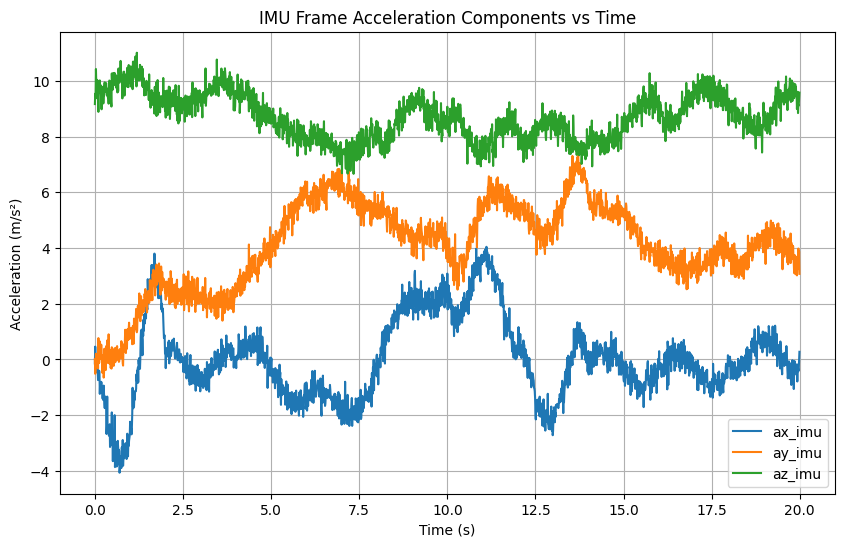

In [35]:
import matplotlib.pyplot as plt

# Plot IMU acceleration components
plt.figure(figsize=(10, 6))
plt.plot(t, acc_imu[:, 0], label='ax_imu')
plt.plot(t, acc_imu[:, 1], label='ay_imu')
plt.plot(t, acc_imu[:, 2], label='az_imu')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.title('IMU Frame Acceleration Components vs Time')
plt.legend()
plt.grid(True)
plt.show()

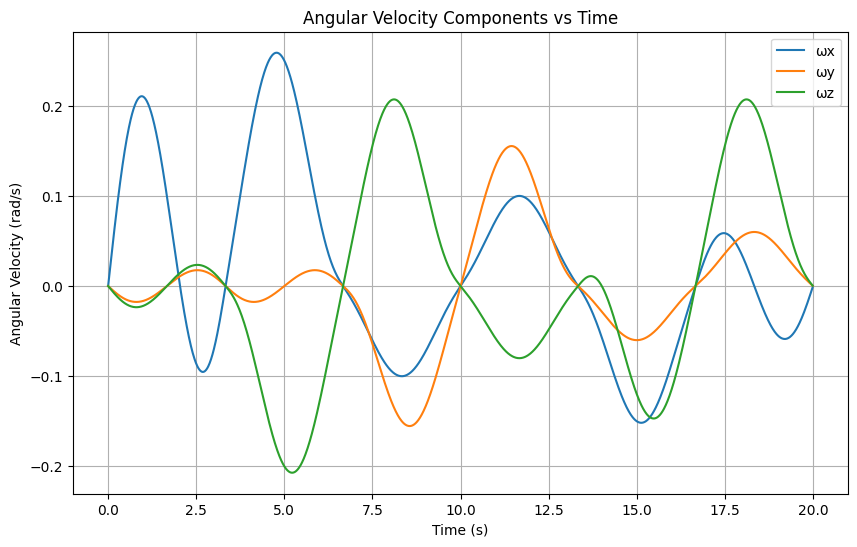

In [36]:
# Plot angular velocity components
plt.figure(figsize=(10, 6))
plt.plot(t, omega[:, 0], label='ωx')
plt.plot(t, omega[:, 1], label='ωy') 
plt.plot(t, omega[:, 2], label='ωz')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Angular Velocity Components vs Time')
plt.legend()
plt.grid(True)
plt.show()


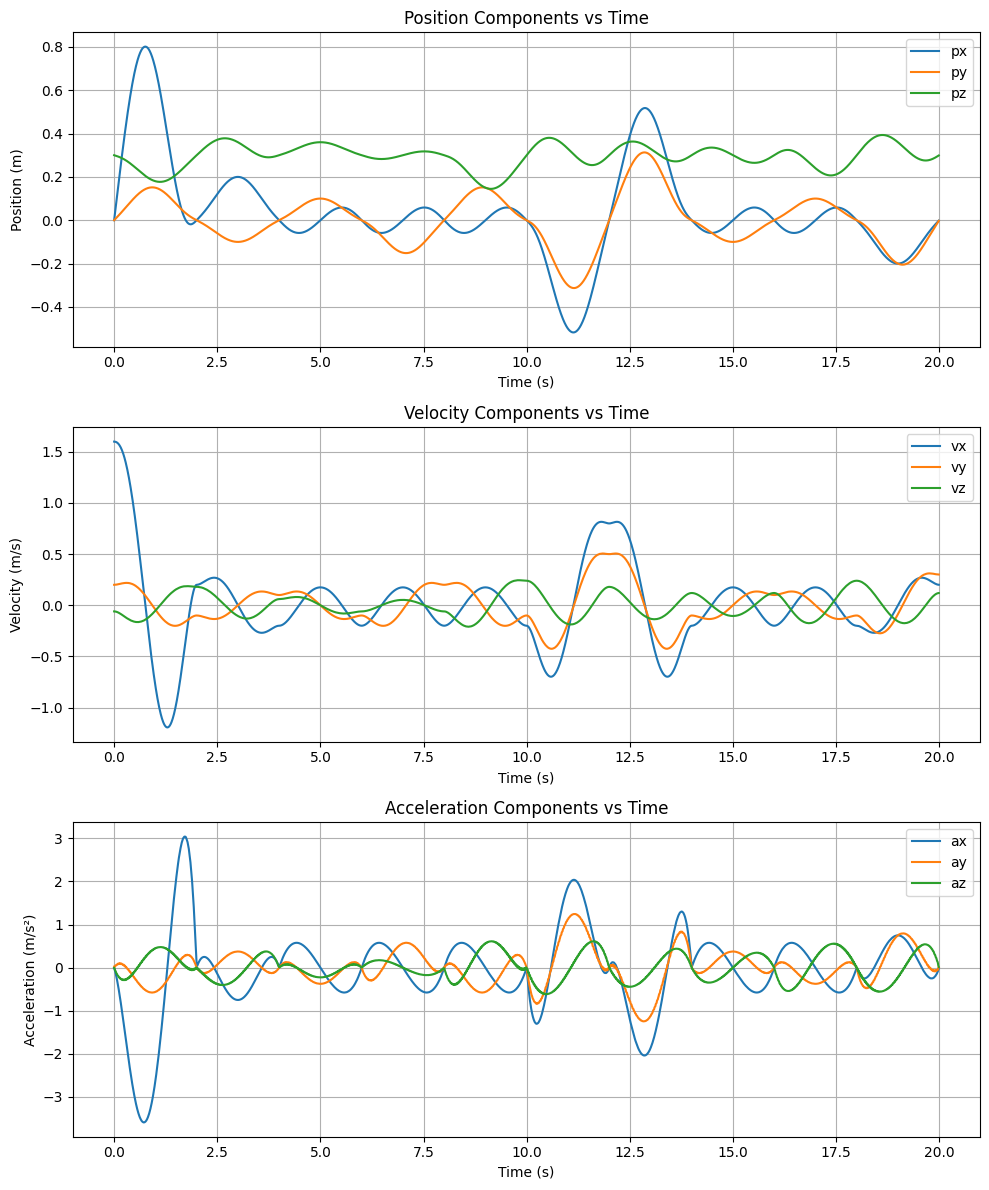

In [37]:

# Plot position, velocity and acceleration components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Position plot
ax1.plot(t, p[:, 0], label='px')
ax1.plot(t, p[:, 1], label='py')
ax1.plot(t, p[:, 2], label='pz')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Position (m)')
ax1.set_title('Position Components vs Time')
ax1.legend()
ax1.grid(True)

# Velocity plot
ax2.plot(t, v[:, 0], label='vx')
ax2.plot(t, v[:, 1], label='vy')
ax2.plot(t, v[:, 2], label='vz')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Velocity (m/s)')
ax2.set_title('Velocity Components vs Time')
ax2.legend()
ax2.grid(True)

# Acceleration plot
ax3.plot(t, a[:, 0], label='ax')
ax3.plot(t, a[:, 1], label='ay')
ax3.plot(t, a[:, 2], label='az')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Acceleration (m/s²)')
ax3.set_title('Acceleration Components vs Time')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()


In [38]:
q_array

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 1.79432693e-05, -1.79427385e-06, -2.39236513e-06,
         1.00000000e+00],
       ...,
       [ 1.79544162e-01,  1.40792948e-03, -1.42567547e-03,
         9.83747874e-01],
       [ 1.79526482e-01,  1.41197593e-03, -1.41757201e-03,
         9.83751106e-01],
       [ 1.79514669e-01,  1.41467812e-03, -1.41216890e-03,
         9.83753266e-01]])